In [46]:
import numpy as np
import pandas as pd

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from matplotlib import pyplot as plt

import http
import requests
import yfinance as yf

In [47]:
api_key = "b5569108b07766dcb23028a5de53e385"

In [48]:
# This is how we get the series_id

# request_for_allReleases = f"https://api.stlouisfed.org/fred/series/search?search_text=volatility+index&api_key={api_key}&file_type=json"
# data = requests.get(request_for_allReleases).json()
# data

In [49]:
request_for_VIX = f"https://api.stlouisfed.org/fred/series/observations?series_id=VIXCLS&api_key={api_key}&file_type=json"
vix_data = requests.get(request_for_VIX).json()

request_for_VXV = f"https://api.stlouisfed.org/fred/series/observations?series_id=VXVCLS&api_key={api_key}&file_type=json"
vxv_data = requests.get(request_for_VXV).json()

In [50]:
vix_value = []
vix_date = []
for data in vix_data["observations"]:
    if (data["value"] != "."):
        vix_value.append(float(data["value"]))
        vix_date.append(data["date"])

vxv_value = []
vxv_date = []
for data in vxv_data["observations"]:
    if (data["value"] != "."):
        vxv_value.append(float(data["value"]))
        vxv_date.append(data["date"])


offset = len(vix_value) - len(vxv_value)

In [51]:
vix_value = vix_value[offset - 4:]
vix_date = vix_date[offset - 4:]

for i in range(len(vix_date)):
    if (i < len(vxv_date) and vix_date[i] != vxv_date[i]):
        vix_value.remove(vix_value[i])
        vix_date.remove(vix_date[i])

        i -= 1

vix_value = np.array(vix_value)
vxv_value = np.array(vxv_value)
vix_value.shape, vxv_value.shape

signal = vix_value - vxv_value
signal

array([-0.86, -0.8 , -1.14, ..., -0.6 , -0.88, -0.27])

In [52]:
vxv_date[0], vxv_date[-1]

('2007-12-04', '2022-10-06')

In [53]:
symbol = '^GSPC'
df = yf.download(symbol, start="2007-12-05", end="2022-10-07")
SP500 = df["Close"].to_numpy()

symbol = 'IEF'
df = yf.download(symbol, start="2007-12-05", end="2022-10-07")
IEF = df["Adj Close"].to_numpy()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [54]:
print("vix value:", vix_value.shape)
print("vxv value:", vxv_value.shape)
print("vix date:", len(vix_date))
print("vxv date:", len(vxv_date))
print("S&P500:", SP500.shape)
print("IEF:", IEF.shape)

vix value: (3737,)
vxv value: (3737,)
vix date: 3737
vxv date: 3737
S&P500: (3737,)
IEF: (3737,)


In [55]:
date = df.index.to_numpy()

In [56]:
new_signal = signal > 0
new_signal = np.diff(new_signal.astype(int))
new_signal = np.insert(new_signal, 0, 0.0, axis = 0)
# print(new_signal.tolist())
# for i in range(1, len(new_signal) + 1):
#     print(i, new_signal[i - 1])

In [57]:
init_money = 1000
init_storage = 0.0
fee_rate = 0.001
money_profit = 0.0002

In [58]:
def trade(money, storage, side, price):
    if side == -1:
        storage += money / (price * (1 + fee_rate))
        money -= money
    elif side == 1:
        money += storage * price * (1 - fee_rate)
        storage -= storage
    return money, storage


In [59]:
money = init_money
storage = init_storage


aggregate_profits = []
trade(money, storage, -1, SP500[0])
for i in range(len(SP500)):
    money, storage = trade(money, storage, new_signal[i], SP500[i])
    aggregate_profits.append((money * (1 + money_profit) + storage * SP500[i] - init_money) / init_money)
aggregate_profits = np.array(aggregate_profits)

In [60]:
year_num = len(vxv_date) / 260

APY: 50.68738718879695
Aggregate 36267.11581253098


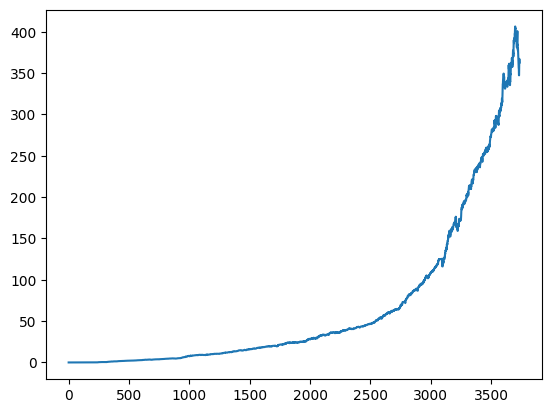

In [61]:
print("APY:", (aggregate_profits[-1] ** (1 / year_num) - 1) * 100)
print("Aggregate", aggregate_profits[-1] * 100)
plt.plot(aggregate_profits)
plt.show()

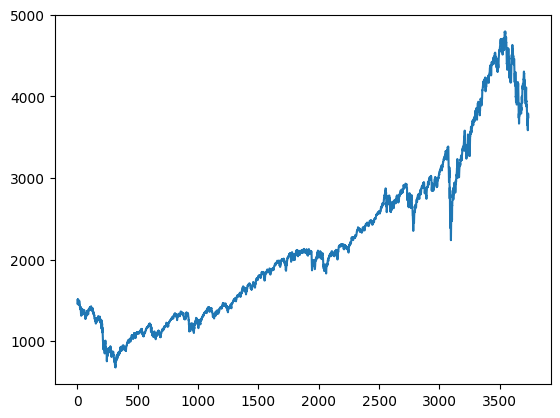

In [63]:
plt.plot(SP500)

In [62]:
# window_size = 260
# off = 260
# start = 0

# profit = []
# while start + window_size < vix_value.shape[0]:
#     money = init_money
#     storage = init_storage

#     local_signal = new_signal[start:start + window_size] != 0
#     local_SP500 = SP500[start:start + window_size][local_signal]
#     local_signal = (new_signal[start:start + window_size])[local_signal]

#     trade(money, storage, -1, SP500[start])

#     for i in range(len(local_signal)):
#         money, storage = trade(money, storage, local_signal[i], local_SP500[i])

#     profit.append((money + storage * SP500[start + window_size - 1] - init_money) / init_money)

#     start += off